# 高斯分布
-> 高斯分布（正态分布）是一个常见的连续概率分布，在统计领域有非常重要的作用。\
**一维** \
$ {\rm{N}}(x;m,\delta ) = \frac{1}{{\delta \sqrt {2\pi } }}{e^{ - \frac{{{{(x - \mu )}^2}}}{{2{\delta ^2}}}}}$ \
**多维** \
${\rm{N}}(x;m,\Sigma ) = \frac{1}{{{{(2\pi )}^{\frac{D}{2}}}{{\left| \Sigma  \right|}^{\frac{1}{2}}}}}{e^{ - \frac{1}{2}(x - m){\Sigma ^{ - 1}}{{(x - m)}^T}}}$
## 利用高斯函数拟合一组数据的分布
假设有一组数据$x_i$, 求最大似然：\
$\sum\limits_{i = 1}^N {\log (N({x_i};m,\Sigma ))} $\
对上式求解：

* $ \Sigma  = \frac{1}{N}\sum\limits_{i = 1}^N {({x_i} - m){{({x_i} - m)}^T}} $
* $ m = \frac{1}{N}\sum\limits_{i = 1}^N {{x_i}} $

In [1]:
# 导包
import numpy as np
import matplotlib.pyplot as plt 


In [2]:
# GMM 参数初始化
# dataset: [N, D] 训练数据
# K ； 高斯成分的个数
def inti_GMM(dataset, K):
    N, D = np.shape(dataset)
    val_max = np.max(dataset, axis = 0)
    val_min = np.min(dataset, axis = 0)
    centers = np.linspace(val_min, val_max, num = K + 2)

    mus = centers[1:-1, :]
    sigmas = np.array([0.5 * np.eye(D) for i in range(K)])
    ws = 1.0 / K * np.ones(K) 
    return mus, sigmas, ws 

In [3]:
# 计算一个高斯的pdf
# x    : 数据 [N, D]
# sigma: 方差 [D, D]
# mu   ：均值 [1, D]
def getPdf (X, mu, sigma, eps = 1e-12) : 
    N, D = np.shape(X)

    if D == 1:
        sigma = sigma + eps
        A = 1.0 / (sigma)
        det = np.fabs(sigma(0))
    else: 
        sigma = sigma + eps * np.eye(D)
        A = np.linalg.inv(sigma)
        det = np.fabs(np.linalg.det(sigma))
    # 计算系数
    factor = (2.0 * np.pi) ** (D / 2.0) * (det) ** (0.5)
    # 计算pdf
    dx = X - mu 
    pdf = [ (np.exp(-0.5 * np.dot(np.dot(dx[i], A), dx[i])) + eps) / factor for i in range(N) ]
    return pdf 

In [4]:
def train_GMM_step(dataset, mus, sigmas, ws) : 
    N, D = np.shape(dataset)
    K, D = np.shape(mus)
    # 计算样本在每个成分上的pdf
    pdfs = np.zeros([N, K])
    for k in range(K): 
        pdfs[:, k] = getPdf(dataset, mus[k], sigmas[k])

    # 获取r
    r = pdfs * np.tile(ws, (N,1))
    r_sum = np.tile(np.sum(r, axis = 1, keepdims = True),(1, K))
    r = r / r_sum

    # 进行参数更新
    for k in range(K):
        r_k = r[:, k]
        N_k = np.sum(r_k) 
        r_k = r_k[:, np.newaxis] # [N, 1]

        # 更新 mu
        mu = np.sum(dataset * r_k, axis = 0) / N_k # [D, 1]

        # 更新sigma 
        dx = dataset - mu 
        sigma = np.zeros([D, D])
        for i in range(N):
            sigma = sigma + r_k[i, 0] * np.outer(dx[i], dx[i])
        sigma = sigma/N_k

        # 更新w
        w = N_k/N 
        mus[k] = mu 
        sigmas[k] = sigma
        ws[k]  = w 
    return mus, sigmas, ws 

In [5]:
def train_GMM(dataset, K = 2, m = 10): 
    mus, sigmas, ws = inti_GMM(dataset, K) 

    for i in range(m):
        #print("Step", i )
        mus, sigmas, ws = train_GMM_step(dataset, mus, sigmas, ws) 
    return mus, sigmas, ws

In [6]:
def getlogPdfFromeGMM(datas, mus, sigmas, ws): 
    N, D = np.shape(datas)
    K, D = np.shape(mus) 

    weightedlogPdf = np.zeros([N, K])

    for k in range(K):
        temp = getPdf(datas, mus[k], sigmas[k], eps = 1e-12)
        weightedlogPdf[:, k] = np.log(temp) + np.log(ws[k])
    return weightedlogPdf, np.sum(weightedlogPdf, axis = 1) 


In [7]:
def clusterByGMM(data, mus, sigmas, ws):
    weightedlogPdf, _ = getlogPdfFromeGMM(data, mus, sigmas, ws)
    labs = np.argmax(weightedlogPdf, axis = 1)
    return labs

In [8]:
def draw_cluster(dataset, lab, dic_colors, name = '0'): 
    plt.cla()
    vals_lab = set(lab.tolist())

    for i, val in enumerate(vals_lab):
        index = np.where(lab == val)[0]
        sub_dataset = dataset[index, :]
        plt.scatter(sub_dataset[:, 0], sub_dataset[:, 1],s = 16, color = dic_colors[i])

    plt.title(name)
    plt.show()

In [9]:
# 导入数据
from sklearn.datasets import load_iris
iris = load_iris()
X_train = iris.data
y_train = iris.target

In [10]:
dic_colors = ['r','g','b']

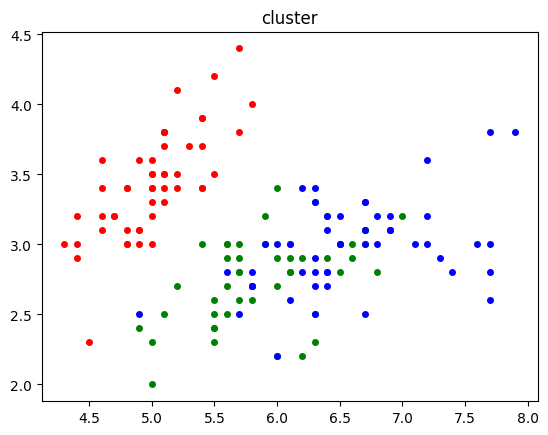

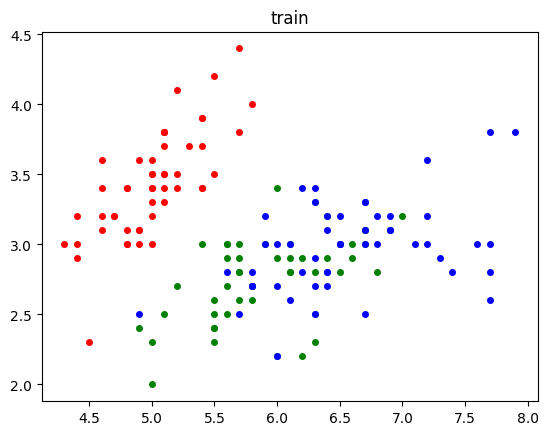

In [11]:
# 训练GMM
mus, sigmas, ws = train_GMM(X_train, K = 3, m = 10)
# print(mus)
# print(sigmas)
# print(ws)
# 进行聚类
labs_GMM = clusterByGMM(X_train, mus, sigmas, ws) 

draw_cluster(X_train, y_train, dic_colors, name = 'cluster') 

draw_cluster(X_train, labs_GMM, dic_colors, name = 'train')

In [12]:
# 生成环形数据
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.datasets import make_circles

X_train, y_train = make_circles(n_samples = 1000, factor = 0.5, noise = 0.1)


In [13]:
# 绘图
def draw_test(datasets, labs, dic_colors = None, name = ''): 
    plt.cla()

    n_lab = set(labs.tolist())
    for i, val in enumerate(n_lab): 
        index = np.where( labs == val )[0]
        sub_dataset = datasets[index, : ]
        plt.scatter(sub_dataset[:, 0], sub_dataset[:, 1], s=16.,color = dic_colors[i])
    plt.title(name)
    plt.show()

dic_colors = ['r', 'g', 'b']

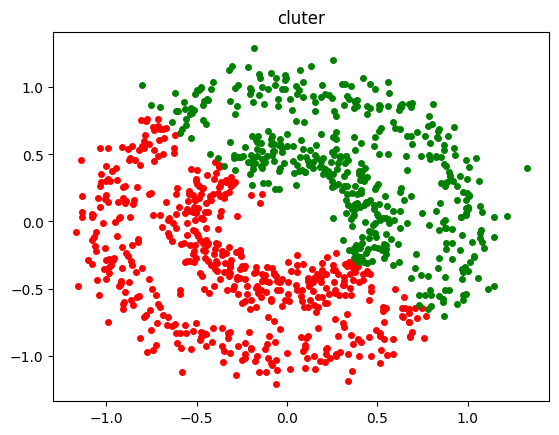

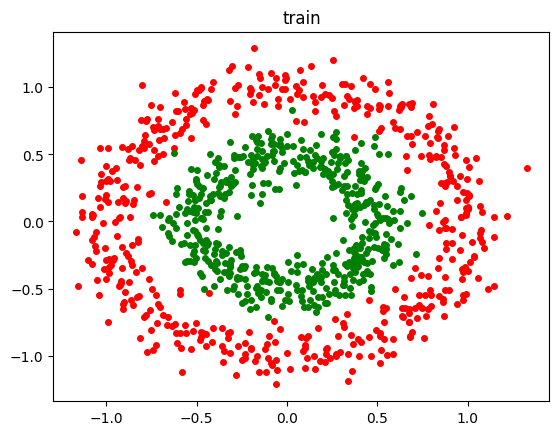

In [15]:
# GMM训练环形数据
# 训练GMM
mus, sigmas, ws = train_GMM(X_train, K = 2, m = 10)

y_pre = clusterByGMM(X_train, mus, sigmas, ws) 

draw_test(X_train, y_pre, dic_colors, name = 'cluter') 

draw_test(X_train, y_train, dic_colors, name = 'train')